Problem 4 : Semantic Segmentation 
a)Understand the PASCAL VOC dataset http://host.robots.ox.ac.uk/pascal/VOC/voc2012/index.html#data
b)Understand the definition of semantic segmentation 
c)Download few images and understand the annotation format 
d)Randomly select a few images and plot the annotations
e)How will you define IOU for a segmentation task? How mid it different from the IOU for an object detection task?


Pascal VOC Dataset:
    Pascal VOC Dataset consists of the image ,annotation (.xml format) which is used for detecting the image and in the annotation dataset,the <segment> tag inside the source is set as 1 which means the image is segmented.Also had given segmented image from the original_mask or binary_mask which is in black and white or gray scale can be separately plotted for each class in the image by retrieving bgr format of the given segmented image.

Semantic Segmentation:
Semantic Segmentation is a process in computer vision that involves classifying each pixel in an image into a predefined category. The goal is to assign a label to every pixel, so that pixels with the same label belong to the same object class.

Annotation format:
    Annotation has the name of each object and as usual it has xmin,xmax,ymin,ymax for detecting the object in the <object> tag and it also has <segment> which is marked as 1 that means the image is segmented.
    
<size>: This tag contains information about the size of the image.

<depth>: Refers to the number of channels in the image. A depth of 3 typically indicates a color image (RGB or BGR).

<height>: Specifies the height of the image in pixels.

<width>: Specifies the width of the image in pixels.

Procedure
1. Parse the xml file for detecting the object position in both
    1.1 Original Image and also
    1.2 Segmented Image
2. Then find bgr format of the colors of the object in Segmented Image
3. From that bgr format,find binary mask for each object or classes separetely in the segmented image
4. Follow some morphological techniques like
     4.1 Erosion
     4.2 Dilation
   to find the predicted_mask from the given binary truth (ground_truth_mask)
5. Find iou score for the predicted_mask and the original ground_truth mask

In [1]:
#Importing libraries that are needed to perform Object Detection
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import xml.etree.ElementTree as ET


In [27]:
def plotAnnotation(fileroot,imgtype):
    filename="2011_001730"
    filepath=fileroot+"/"+filename+"."+imgtype
    print("File path",filepath)
    annotpath="Annotations/Annotations/"+filename+".xml"
    tree=ET.parse(annotpath)
    root=tree.getroot()
    img=cv2.imread(filepath)
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    #In the xml file find the tag which object which is nested in the annndbox ,find value of xmin,ymin,xmax,ymax in the bndbox tag and convert it to into integer for further calculation of Bounding boxotations(root)
    for obj in root.findall('object'):
        #find the tag bndbox within the object tag
        imgname=obj.find('name').text
        box = obj.find('bndbox')
        """In
       bndbox ,find value of xmin,ymin,xmax,ymax in the bndbox tag 
    and convert it to into integer for further calculation of Bounding box"""
        
        xmin = int(box.find('xmin').text)
        ymin = int(box.find('ymin').text)
        xmax = int(box.find('xmax').text)
        ymax = int(box.find('ymax').text)
        ai_rect = patches.Rectangle((xmin,ymin ), xmax - xmin ,ymax - ymin , linewidth=2, edgecolor='orange', facecolor='none', fill=False)
        plt.gca().add_patch(ai_rect)
        plt.text(xmin, ymin, imgname, bbox=dict(facecolor='white', alpha=0.3))
   
    plt.axis("off")
    plt.show()

    
    

File path JPEGImages/2011_001730.jpg


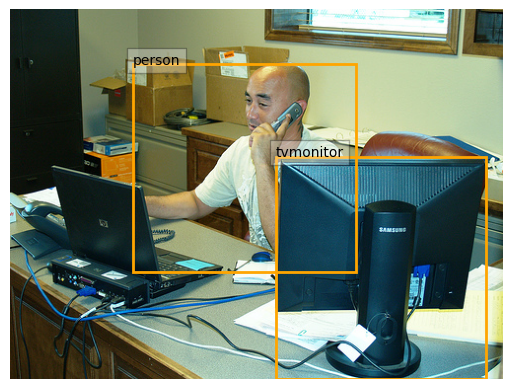

In [28]:
#Plot Annotation for the original image
plotAnnotation('JPEGImages','jpg')

File path SegmentationClass/SegmentationClass/2011_001730.png


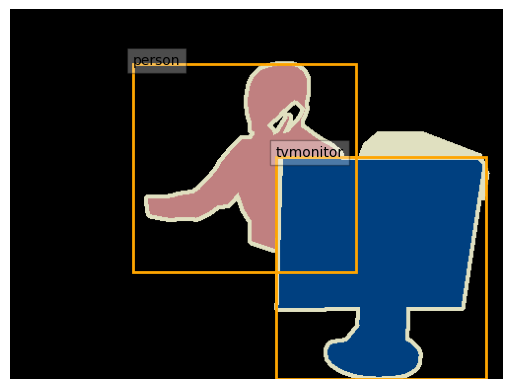

In [29]:
#Plot annotation for the segmented image
plotAnnotation('SegmentationClass/SegmentationClass','png')

In [63]:
#Generate binary_mask for the given segmented image using bgr format of each classes in the image
def generate_binary_masks(segmented_image, class_colors):
    masks = []
    for color in class_colors:
        # Convert the color to a numpy array
        color = np.array(color, dtype=np.uint8)
        mask = cv2.inRange(segmented_image, color, color)
        masks.append(mask)
    return masks
    


In [68]:
#Finding bgr for the colors in the segmented image
# Path to the segmented image
image_path = 'SegmentationClass/SegmentationClass/2011_001730.png'  # Replace with the actual path to your segmented image

# Read the segmented image in BGR format
segmented_image_bgr = cv2.imread(image_path)

# Check if the image was read successfully
if segmented_image_bgr is not None:
    print("Image was read successfully.")

    # Get the height and width of the image
    height, width, _ = segmented_image_bgr.shape

    # Create an empty set to store unique BGR values
    unique_bgr_values = set()

    # Iterate through each pixel in the image
    for y in range(height):
        for x in range(width):
            # Get the BGR value of the current pixel
            bgr_value = tuple(segmented_image_bgr[y, x])
            # Add the BGR value to the set of unique values
            unique_bgr_values.add(bgr_value)

    # Print the unique BGR values
    print("Unique BGR values in the segmented image:")
    for bgr_value in unique_bgr_values:
        print(bgr_value)
else:
    print("Error reading the image.")

Image was read successfully.
Unique BGR values in the segmented image:
(0, 0, 0)
(128, 128, 192)
(192, 224, 224)
(128, 64, 0)


In [77]:
image_path = 'SegmentationClass/SegmentationClass/2011_001730.png'  # Replace with your image path
# Read the segmented image
segmented_image = cv2.imread(image_path)
class_colors = [(128, 128, 192),(128, 64, 0)] #(bgr color format of the image tvmonitor and person in the segmented image)
#Generate binary_mask(ground_truth_box) using segmented_image and class_colors ie.color of each class in segmented image in bgr
binary_mask = generate_binary_mask(segmented_image,class_colors)

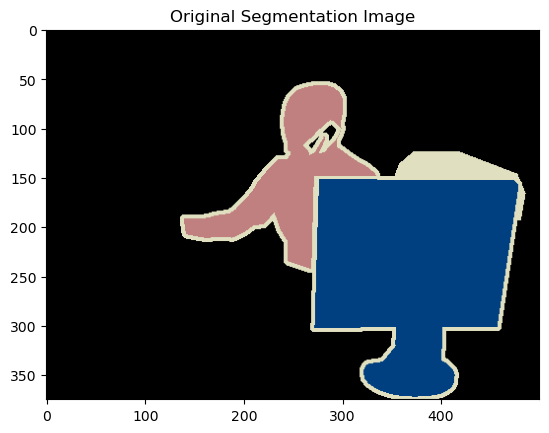

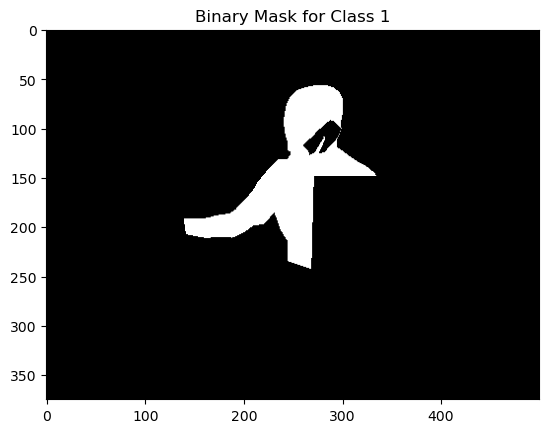

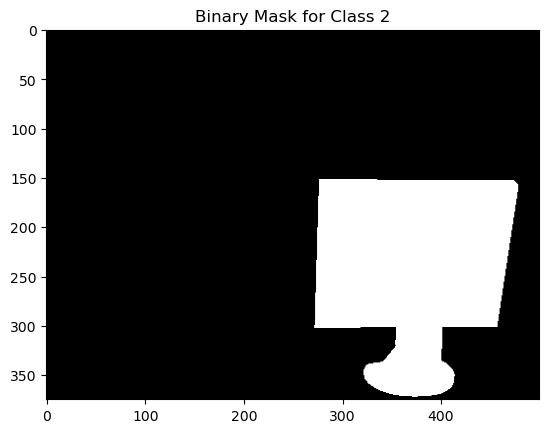

In [78]:
 # Display the original image
plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
plt.title('Original Segmentation Image')
plt.show()

# Display the masks for each class
for i, mask in enumerate(binary_mask):
    plt.imshow(mask, cmap='gray')
    plt.title(f'Binary Mask for Class {i + 1}')
    plt.show()

In [89]:
#Predicted mask from binary mask using morphological techniques like erosion and dilation
def predicted_mask(binary_mask):
    predict_mask=[]
    # Define the kernel (structuring element)
    kernel_size = (5, 5)  # You can change the size according to your needs
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
    for mask in binary_mask:
      # Apply erosion
      eroded_mask = cv2.erode(mask, kernel, iterations=1)
   # Apply dilation
      dilated_mask = cv2.dilate(eroded_mask, kernel, iterations=1)
      predict_mask.append(dilated_mask)
    return predict_mask


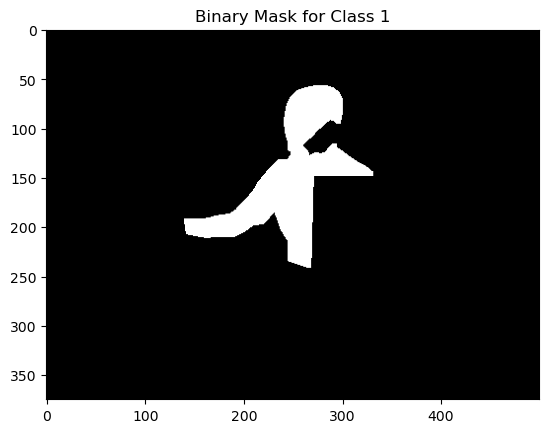

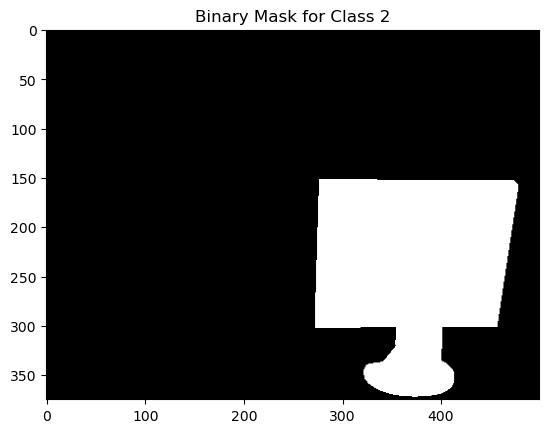

In [90]:
predict_mask=predicted_mask(binary_mask)
# Display the predicted  masks by applying morphological techniques for each class
for i, mask in enumerate(predict_mask):
    plt.imshow(mask, cmap='gray')
    plt.title(f'Binary Mask for Class {i + 1}')
    plt.show()

In [91]:
#Calculate iou score between the original binary_mask and the predicted_mask for each class
def iou(predict_mask,binary_mask):
    iou_sc=[]
    for i,mask in enumerate(binary_mask):
        intersect=np.logical_and(predict_mask[i],mask)
        union=np.logical_or(predict_mask[i],mask)
        iou_val=np.sum(intersect)/np.sum(union)
        iou_sc.append(iou_val)
    return iou_sc

In [93]:
#Display
iou_sc=iou(predict_mask,binary_mask)
for i,iou_score in enumerate(iou_sc):
    print("IOU Score for class {0} is {1:.6f}".format(i+1,iou_score))

IOU Score for class 1 is 0.991818
IOU Score for class 2 is 0.999851
